In [1]:
!python libraries.py

2024-08-30 17:40:00,703 - INFO - Upgrading pip...
2024-08-30 17:40:00,703 - INFO - Running pip command: install --upgrade pip
2024-08-30 17:40:02,513 - INFO - Command 'install --upgrade pip' executed successfully.
2024-08-30 17:40:02,513 - INFO - pip upgraded successfully.
2024-08-30 17:40:02,513 - INFO - Installing library numpy...
2024-08-30 17:40:02,513 - INFO - Running pip command: install numpy
2024-08-30 17:40:03,882 - INFO - Command 'install numpy' executed successfully.
2024-08-30 17:40:03,882 - INFO - numpy installed successfully.
2024-08-30 17:40:03,882 - INFO - Installing library pandas...
2024-08-30 17:40:03,882 - INFO - Running pip command: install pandas
2024-08-30 17:40:05,120 - INFO - Command 'install pandas' executed successfully.
2024-08-30 17:40:05,120 - INFO - pandas installed successfully.
2024-08-30 17:40:05,120 - INFO - Installing library matplotlib...
2024-08-30 17:40:05,120 - INFO - Running pip command: install matplotlib
2024-08-30 17:40:06,271 - INFO - Comman

In [2]:
import os
from config import Config

config = Config(
    data_dir='./data',
    train_data_subdir='train/',
    val_data_subdir='test/',
    test_data_subdir='test/',
    models_dir='./models',
    dl_models_subdir='dl/',
    ml_models_subdir='ml/'
)

data_dir = ['.ipynb_checkpoints', 'features.txt', 'targets.txt', 'test', 'test_file_idx.txt', 'train', 'val']
train_data_dir = ['TRAIN_LGHG2@n10degC_to_25degC_Norm_5Inputs.csv']
val_data_dir = ['01_TEST_LGHG2@n10degC_Norm_(05_Inputs).csv', '02_TEST_LGHG2@0degC_Norm_(05_Inputs).csv', '03_TEST_LGHG2@10degC_Norm_(05_Inputs).csv', '04_TEST_LGHG2@25degC_Norm_(05_Inputs).csv']
test_data_dir = ['01_TEST_LGHG2@n10degC_Norm_(05_Inputs).csv', '02_TEST_LGHG2@0degC_Norm_(05_Inputs).csv', '03_TEST_LGHG2@10degC_Norm_(05_Inputs).csv', '04_TEST_LGHG2@25degC_Norm_(05_Inputs).csv']
models_dir = ['.ipynb_checkpoints', 'dl', 'ml']
dl_models_dir = ['rnn_model.keras']
ml_models_dir = ['soc_estimation_ml_decisiontree.sav', 'soc_estimation_ml_lregression.sav', 'soc_estimation_ml_nnregression.sav']


In [3]:
import pandas as pd
import numpy as np

## Testing Data

In [4]:
test_file_idx_filename = 'test_file_idx.txt'
test_file_idx_path = os.path.join(config.get_data_dir(), test_file_idx_filename)
with open(test_file_idx_path, 'r') as file:
    test_file_idx = [int(idx.strip()) for idx in file.readlines()]

In [5]:
test_data_filename = os.listdir(config.get_test_data_dir())[test_file_idx[0]]
test_data_path = os.path.join(config.get_test_data_dir(), test_data_filename)
test_data = pd.read_csv(test_data_path)
test_data.columns

Index(['V', 'I', 'Temp', 'V_avg', 'I_avg', 'SOC'], dtype='object')

### Extracting Features for Testing
In this cell, we extract specific features from the testing data for use in model testing

In [6]:
targets_filename = 'targets.txt'
targets_path = os.path.join(config.get_data_dir(), targets_filename)
with open(targets_path, 'r') as file:
    targets = [target.strip() for target in file.readlines()]

features_filename = 'features.txt'
features_path = os.path.join(config.get_data_dir(), features_filename)
with open(features_path, 'r') as file:
    features = [feature.strip() for feature in file.readlines()]

print(f'features = {features}')
print(f'target = {targets}')

features = ['I', 'Temp', 'V_avg', 'I_avg', 'V']
target = ['SOC']


In [7]:
X_test = test_data[features].values
X_test.shape

(47517, 5)

In [8]:
X_test

array([[0.74890031, 0.92067815, 0.96696018, 0.74890031, 0.96696018],
       [0.74699217, 0.92067726, 0.96649   , 0.74794624, 0.96601981],
       [0.74699223, 0.91784518, 0.9662938 , 0.74762823, 0.9659014 ],
       ...,
       [0.75102009, 0.9263438 , 0.2927976 , 0.75102009, 0.29861375],
       [0.75102009, 0.92917676, 0.2928344 , 0.75102009, 0.29861375],
       [0.75102009, 0.92917676, 0.29287091, 0.75102009, 0.29861375]])

### Extracting Target Variable for Testing

In this cell, we extract the target variable from the testing data

In [9]:
y_test = test_data[targets].values
y_test.shape

(47517, 1)

In [10]:
y_test

array([[1.        ],
       [0.99999   ],
       [0.99998333],
       ...,
       [0.13662333],
       [0.13662333],
       [0.13662333]])

## Data Normalization

In [11]:
import utils

In [12]:
normalized_X_test = utils.normalize(X_test)
normalized_X_test

array([[-1.        ,  0.57551079,  1.        , -1.        ,  1.        ],
       [-1.        ,  0.58256774,  1.        , -0.99130679,  0.99571585],
       [-1.        ,  0.55815534,  1.        , -0.99419975,  0.99642139],
       ...,
       [ 0.44653221,  1.        , -1.        ,  0.44653221, -0.98163938],
       [ 0.44006032,  1.        , -1.        ,  0.44006032, -0.98183573],
       [ 0.44002819,  1.        , -1.        ,  0.44002819, -0.98194943]])

# RNN Testing

In [13]:
from tensorflow import keras
from custom import CustomLeakyReLU, CustomClippedReLU

In [14]:
saved_model_name = 'rnn_model.keras'
saved_model_path = os.path.join(config.get_dl_models_dir(), saved_model_name)
model = keras.models.load_model(
    saved_model_path, 
    custom_objects={
        'CustomLeakyReLU': CustomLeakyReLU,
        'CustomClippedReLU': CustomClippedReLU
    }
)

In [15]:
y_predicted = model.predict(normalized_X_test)
y_predicted

1485/1485 ━━━━━━━━━━━━━━━━━━━━ 2s 948us/step


array([[1.        ],
       [0.9968414 ],
       [0.99955195],
       ...,
       [0.14000113],
       [0.13980083],
       [0.13970536]], dtype=float32)

In [16]:
results = model.evaluate(normalized_X_test, y_test)

1485/1485 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step - loss: 7.8267e-04


In [17]:
import utils
rnn_metrics = utils.get_metrics(y_test, y_predicted)
rnn_metrics

,Metric,Value
0,max_error,0.234332
1,mean_absolute_error,0.019947
2,mean_absolute_percentage_error,0.056672
3,mean_squared_error,0.001034
4,root_mean_squared_error,0.032162
5,root_mean_squared_log_error,0.023323


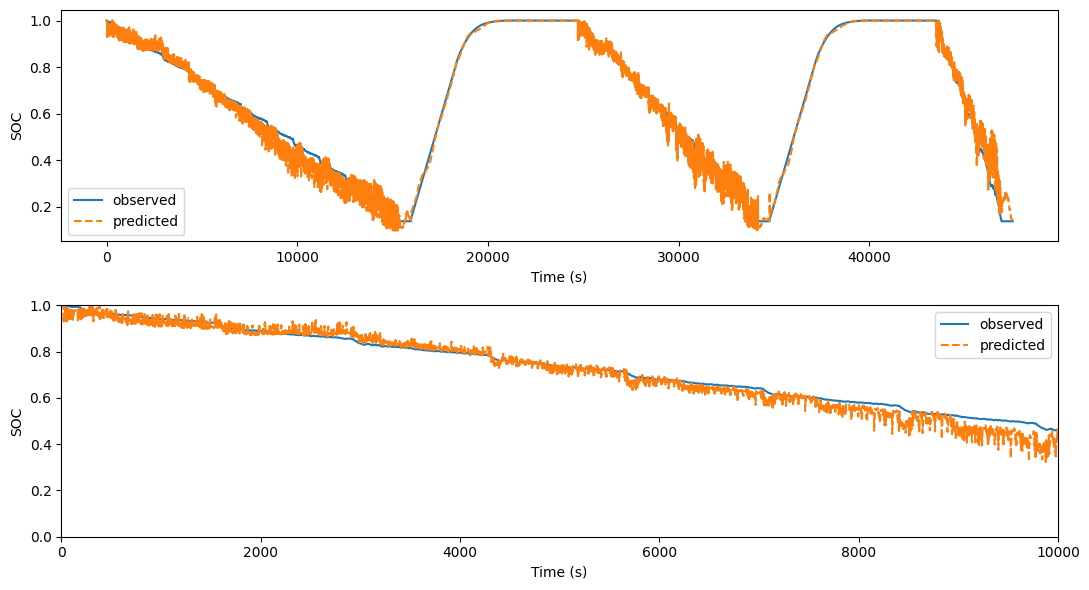

In [18]:
utils.plot_obs_pred(
    y_test=y_test, 
    y_predicted=y_predicted, 
    ylabel='SOC', 
    xlabel='Time (s)'
)